In [1]:
print("hello")

hello


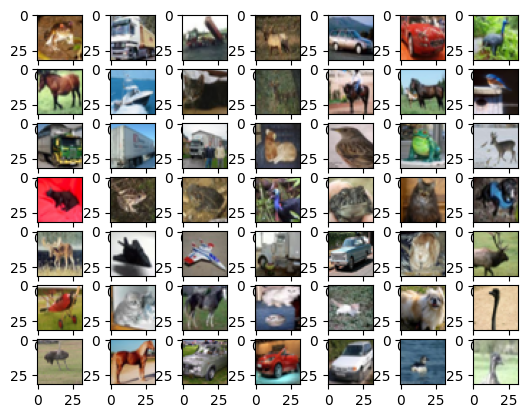

In [2]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

#plot images from the training dataset
for i in range(49):
    #define subplot 
    pyplot.subplot(7,7,i+1)
    # turn od axis
    # plot raw pixel data
    pyplot.imshow(trainX[i])
pyplot.show()




In [3]:
print(trainX.shape)

(50000, 32, 32, 3)


In [4]:
# example pf downsampling with strided convolution
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

from keras.utils.vis_utils import plot_model
import numpy as np

In [5]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    #noraml
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    #downsample 
    model.add(Conv2D(128, (3,3), padding='same', strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    #downsample 
    model.add(Conv2D(128, (3,3), padding='same', strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    #downsample 
    model.add(Conv2D(256, (3,3), padding='same', strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [6]:
import pydot
# define model
model = define_discriminator()
model.summary()
# plot the model
plot_model(model, to_file='./discriminator_plot.png', show_shapes=True, show_layer_names=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

c:\Users\koush\anaconda3\envs\mytf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
# function to load the dataset and scale it
# load and prepare cifar10 trainig images
def load_real_samples():
    # load from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0, 255] to [-1, 1]
    X = (X - 127.5) / 127.5
    return X


In [8]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

In [9]:
# select real sample
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = np.random.rand(32*32*3*n_samples)
    # update to have the range [-1,1]
    X = -1 + X*2
    # reshape into a batch of color images
    X = X.reshape((n_samples, 32, 32, 3))
    # generate 'fake' clas labeles (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [10]:
X,y = generate_fake_samples(64)
print(X.shape)
print(y.shape)
print(y)


(64, 32, 32, 3)
(64, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


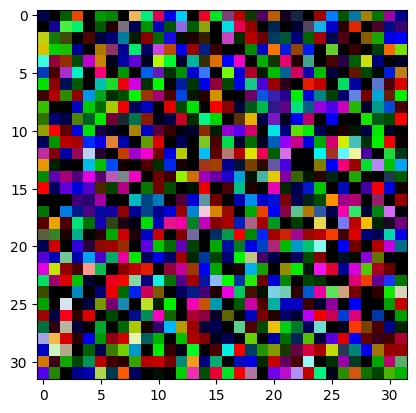

In [11]:
pyplot.imshow(X[0])

In [12]:
# train the discriminator model temporarily
def train_discriminator(model, dataset, n_itel=20, n_batch=128):
    half_batch = int(n_batch / 2)
    # manully enumerate epochs
    for i in range(n_itel):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)

        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)

        # summarize performance
        print('>%d, real=%.0f%%  fake=%.0f%%'
              % (i+1, real_acc*100, fake_acc*100))
        



In [13]:
# example training
#define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
#fit the model
train_discriminator(model, dataset)

>1, real=84%  fake=2%
>2, real=97%  fake=5%
>3, real=98%  fake=6%
>4, real=95%  fake=23%
>5, real=98%  fake=42%
>6, real=100%  fake=61%
>7, real=100%  fake=95%
>8, real=98%  fake=100%
>9, real=95%  fake=100%
>10, real=97%  fake=100%
>11, real=100%  fake=100%
>12, real=97%  fake=100%
>13, real=98%  fake=100%
>14, real=98%  fake=100%
>15, real=98%  fake=100%
>16, real=100%  fake=100%
>17, real=100%  fake=100%
>18, real=100%  fake=100%
>19, real=100%  fake=100%
>20, real=100%  fake=100%


In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

In [15]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    #foundation for 4*4 image
    n_nodes = 256 * 4 *4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #output layer
    model.add(Conv2D(3,(3,3), activation='tanh', padding='same'))
    return model


In [16]:
# define the size of the latent space
latent_dim =100
#define the genetator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [18]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    #generate point in the latent space 
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


In [19]:
x_input = generate_latent_points(100,64)
print(x_input.shape)

(64, 100)


In [23]:
# udr the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model,latent_dim, n_samples):
    # generate points in the latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y




2/2 [==============================] - 1s 82ms/step


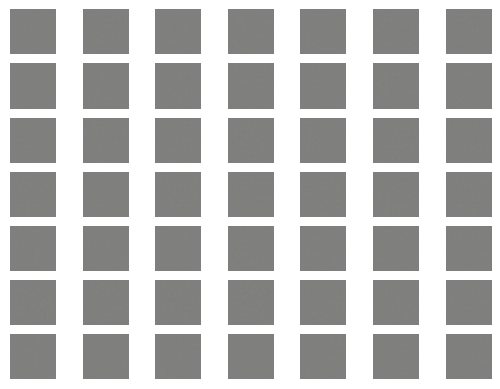

In [24]:
# size the latent space
from matplotlib import pyplot as plt
latent_dim =100
# define the discriminator model
model = define_generator(latent_dim)
# generate sample
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
#scale pixel value from [-1,1] to [0,1]
X = (X+1)/2.0
#plot the genrated samples
for i in range(n_samples):
    #define subplot
    pyplot.subplot(7,7,1+i)
    # turn off axis labels
    pyplot.axis('off')
    # plot the single image
    pyplot.imshow(X[i])
#show the figure

pyplot.show()

In [25]:
# define the combined generator and discriminator model, for updating the genertator
def define_gan(g_model, d_model):
    #make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator 
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model



In [26]:
# size of the latend space 
latent_dim = 100
#create the discriminator 
d_model = define_discriminator()
#create the generator 
g_model = define_generator(latent_dim)
# create the gan model
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_6 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


c:\Users\koush\anaconda3\envs\mytf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
